In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from time import time
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.optimize import minimize

# import cupy as cp

In [117]:
t_min = 0
t_end = 24 * 50

In [153]:
P = math.log(2)/24
X_max = 1.3*10**6
Ser = 1
K_ser = 0
k_DNA = math.log(2)/24
k_s = 3e-2
k_dRNA = 3e-2
k_vp = 1e-2 # 1e-2
K_RNA = 0.2*10**4
k_a = 7.8*10**(-8)
p = 0.8 # 0.8で仮定

X0 = 0.2 * 1e6  # Xの初期値を適切に設定してください
# DNA0 = 5.5 * 1e4  # Okumura
DNA0 = 2.0 * 1e11
DNA0 = DNA0 / X0 * p
RNA0 = 0.0  # Okumura
SRIP0 = 0.0  # SRIPの初期値を適切に設定してください

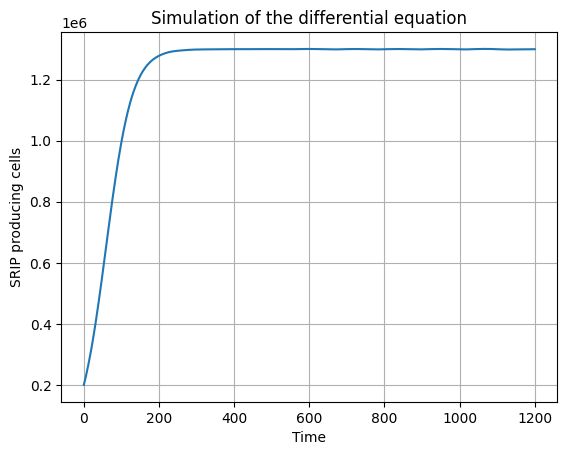

In [154]:
# 微分方程式の定義
def model(t, X):
    dXdt = P * X * (X_max - X) / X_max * Ser / (Ser + K_ser)
    return dXdt

# solve_ivpを使用して微分方程式を解く
sol_cell = solve_ivp(model, [t_min, t_end], [X0], t_eval=np.linspace(t_min, t_end, t_end))

# 結果のプロット
plt.plot(sol_cell.t, sol_cell.y[0])
plt.xlabel('Time')
plt.ylabel('SRIP producing cells')
plt.title('Simulation of the differential equation')
plt.grid(True)
plt.show()

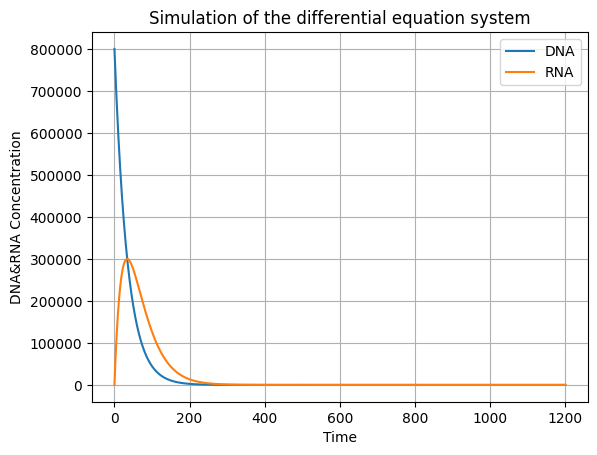

In [155]:
# 微分方程式系の定義
def model(t, y):
    DNA, RNA = y
    dDNAdt = -k_DNA * DNA
    dRNAdt = k_s * DNA - k_dRNA * RNA
    
    return [dDNAdt, dRNAdt]

# solve_ivpを使用して微分方程式系を解く
sol_rna = solve_ivp(model, [t_min, t_end], [DNA0, RNA0], t_eval=np.linspace(t_min, t_end, t_end))

# 結果のプロット
plt.plot(sol_rna.t, sol_rna.y[0], label='DNA')
plt.plot(sol_rna.t, sol_rna.y[1], label='RNA')
plt.xlabel('Time')
plt.ylabel('DNA&RNA Concentration')
plt.title('Simulation of the differential equation system')
plt.legend()
plt.grid(True)
plt.show()

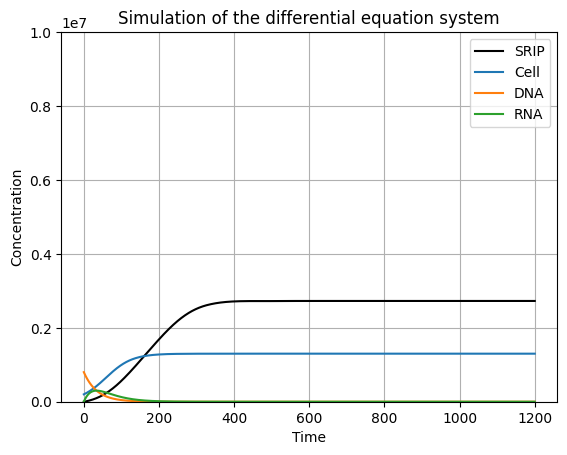

In [161]:
X_values = sol_cell.y[0]
RNA_values = sol_rna.y[1] 

# 微分方程式系の定義
def model(t, SRIP):
    # 時間tにおけるRNAとXの値を取得
    idx = np.searchsorted(sol_rna.t, t, side='right') - 1
    RNA = RNA_values[idx]
    X = X_values[idx]
    
    # SRIPの微分方程式
    # dSRIPdt = k_vp * RNA / (RNA + K_RNA) * X - k_a * SRIP * X
    dSRIPdt = k_vp * RNA / (RNA + K_RNA) * X
    
    # print(t, idx, dSRIPdt)
    return dSRIPdt

# solve_ivpを使用して微分方程式系を解く
sol_srip = solve_ivp(model, [t_min, t_end], [SRIP0], t_eval=np.linspace(t_min, t_end, t_end))

# 結果のプロット
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(sol_srip.t, sol_srip.y[0], label='SRIP', color='black')
ax.set_xlabel('Time')
ax.set_ylabel('Concentration')
ax.set_title('Simulation of the differential equation system')
# ax.axvline(x=48, color='b')
# ax.axvline(x=72, color='b')
ax.set_ylim(0, 1e7)


ax.plot(sol_cell.t, sol_cell.y[0], label='Cell')
ax.plot(sol_rna.t, sol_rna.y[0], label='DNA')
ax.plot(sol_rna.t, sol_rna.y[1], label='RNA')

plt.legend()
plt.grid(True)
plt.show()

In [157]:
data = pd.read_csv('experiment.csv')
data = [[0] + data[str(i)].to_list()[:6] for i in range(1, 4)]
data = [[data[0][i], data[1][i], data[2][i]] for i in range(6)]
# data = [[data[0][i], data[2][i]] for i in range(6)]

In [158]:
data

[[0, 0, 0],
 [8639.484308, 3599.785128, 5039.69918],
 [244785.3887, 59036.4761, 282943.1111],
 [19438.83969, 5759.656205, 17998.92564],
 [2159.871077, 66236.04636, 719.9570257],
 [1439.914051, 0.0, 719.9570257]]

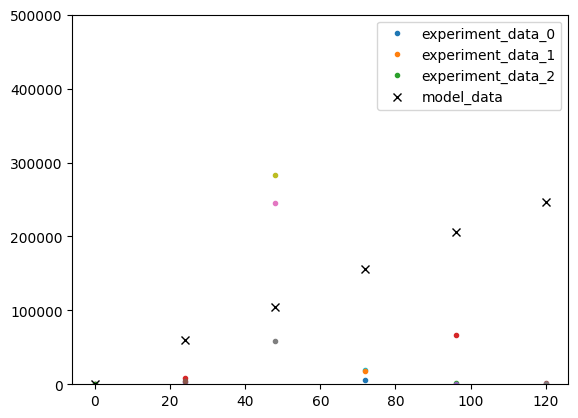

In [159]:
model_res = [sol_srip.y[0][0]] + [sol_srip.y[0][24 * i] - sol_srip.y[0][24 * (i-1)] for i in range(1, 6)]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

i = 0
datum = data[i]
for j in range(len(data[i])):
    ax.plot(24 * i, datum[j], '.', label=f'experiment_data_{j}')
ax.plot(24 * i, model_res[i], 'x', label=f'model_data', color='black')

for i in range(1, 6):
    datum = data[i]
    for j in range(len(data[i])):
        ax.plot(24 * i, datum[j], '.')
    ax.plot(24 * i, model_res[i], 'x', color='black')

ax.set_ylim(0, 5e5)
ax.legend()
plt.show()

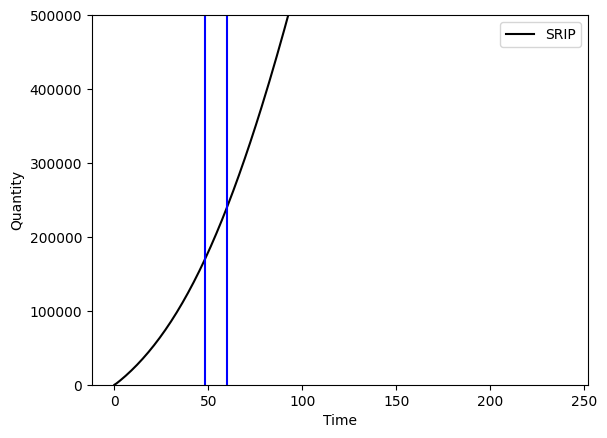

In [104]:
def model(t, y):
    X, DNA, RNA, SRIP = y
    dXdt = P * X * (X_max - X) / X_max * Ser / (Ser + K_ser)
    dDNAdt = -k_DNA * DNA
    dRNAdt = k_s * DNA - k_dRNA * RNA
    dSRIPdt = k_vp * RNA / (RNA + K_RNA) * X
    
    return [dXdt, dDNAdt, dRNAdt, dSRIPdt]


y0 = [X0, DNA0, RNA0, SRIP0]
sol = solve_ivp(model, [t_min, t_end], y0, t_eval=np.linspace(t_min, t_end, t_end))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# ax.plot(sol.t, sol.y[0], label='X')
# ax.plot(sol.t, sol.y[1], label='DNA')
# ax.plot(sol.t, sol.y[2], label='RNA')
ax.plot(sol.t, sol.y[3], label='SRIP', color='black')
ax.axvline(x=48, color='b')
ax.axvline(x=60, color='b')
ax.set_ylim(0, 5e5)


ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Quantity')
ax.set_ylim(0, 5e5)
plt.show()

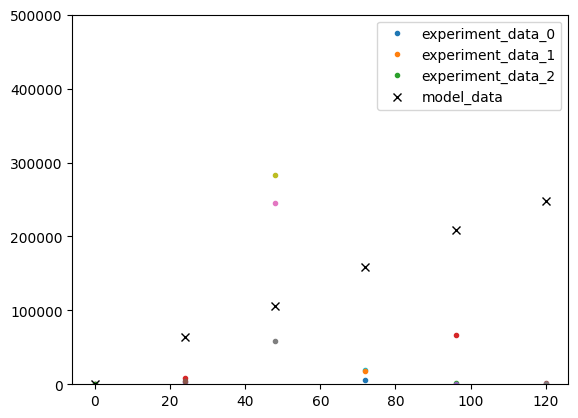

In [94]:
model_res = [sol.y[3][0]] + [sol.y[3][24 * i] - sol.y[3][24 * (i-1)] for i in range(1, 6)]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

i = 0
datum = data[i]
for j in range(len(data[i])):
    ax.plot(24 * i, datum[j], '.', label=f'experiment_data_{j}')
ax.plot(24 * i, model_res[i], 'x', label=f'model_data', color='black')

for i in range(1, 6):
    datum = data[i]
    for j in range(len(data[i])):
        ax.plot(24 * i, datum[j], '.')
    ax.plot(24 * i, model_res[i], 'x', color='black')

ax.set_ylim(0, 5e5)
ax.legend()
plt.show()

In [87]:
sol.y.shape

(4, 240)